# 1. Introduction

This notebook focuses on evaluating the EfficientNet B2 model obtained from the EfficientNetB2_Modeling notebook. The model has been trained without transfer learning, but initialized with pretrained weights. The imput image size is 480x480.

The following table summarizes the characteristics and the training parameters of the selected model.

| Version | **Model Type** | **Image Size** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | EfficientNet B2 | 288x288 | 64 | DEFAULT | 10 | 0.0001 | CosineAnnealingLR | 117.4M |

# 2. Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import seaborn as sns
import torchvision

from typing import List
from torchvision.transforms import v2
from pathlib import Path

from modules.helper_functions import create_dataloaders, set_seeds, load_model
from modules.engine import predict_and_store

# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Create image size
IMG_SIZE = 288

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5],
                 std=[0.5, 0.5, 0.5]) 
])

manual_transforms_aug_norm_test = v2.Compose([        
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5],
                 std=[0.5, 0.5, 0.5]) 
])

In [4]:
# Create data loaders
_, test_dataloader_vit, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# 3. Evaluating EfficientNet B2

The model will be evaluated using the test dataset with the following metrics: accuracy, loss, model size (MB), average prediction time per image (sec), and average predited images per second (frames/sec)

In [5]:
# Load ViT-Base - Version 3: 
model_type="effnetb2"
model_name = f"{model_type}"
effnetb2_model_name = model_name + ".pth"
effnetb2_results_df = model_name + ".csv"

def create_effnetb2(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        hidden_units: int=1024,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    if transfer_learning:
        weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout), 
        torch.nn.Linear(in_features=1408, 
                        out_features=hidden_units, # same number of output units as our number of classes
                        bias=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=dropout), 
        torch.nn.Linear(in_features=hidden_units, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)
    )

    return model, weights

# Instantiate the model
effnetb2_model, _ = create_effnetb2(transfer_learning=False,
                                      class_names=class_names)

# Compile model
effnetb2_model = torch.compile(effnetb2_model, backend="aot_eager")


# Load the trained weights
effnetb2_model = load_model(model=effnetb2_model,
                               model_weights_dir=MODEL_DIR,
                               model_weights_name=effnetb2_model_name)

# Load the training results
effnetb2_results = pd.read_csv(os.path.join(MODEL_DIR, effnetb2_results_df))

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[INFO] Loading model from: ..\models\effnetb2.pth


## 3.1 Making Predictions on the CPU: Intel Core i9-9900K@3.60GHz

In [6]:
# Make predictions on the CPU to compute the average prediction time per image
pred_list_cpu, classif_report_cpu = predict_and_store(
    test_dir=TEST_DIR,
    model=effnetb2_model,
    transform=manual_transforms_aug_norm_test,
    class_names=class_names,
    percent_samples=1,
    device="cpu") # make predictions on CPU

[INFO] Finding all filepaths ending with '.jpg' in directory: ..\data\food-101_100_percent\test


  0%|          | 0/25250 [00:00<?, ?it/s]

## 3.2 Making Predictions on the GPU: NVIDIA GeForce RTX 4070

In [7]:
# Make predictions on the GPU to compute the average prediction time per image
pred_list_gpu, classif_report_gpu = predict_and_store(
    test_dir=TEST_DIR,
    model=effnetb2_model,
    transform=manual_transforms_aug_norm_test,
    class_names=class_names,
    percent_samples=1,
    device=device)

[INFO] Finding all filepaths ending with '.jpg' in directory: ..\data\food-101_100_percent\test


  0%|          | 0/25250 [00:00<?, ?it/s]

## 3.3. Collecting Data

In [8]:
# Create a dictionary with the results for this model, in terms 
effnetb2_dict = {}
effnetb2_dict['Model Name'] = model_name
effnetb2_dict['Test Acc'] = round(effnetb2_results['test_acc'].iloc[-1], 2)
effnetb2_dict['Test los'] = round(effnetb2_results['test_loss'].iloc[-1], 2)
effnetb2_dict['Model Size [MB]'] = round(Path(os.path.join(MODEL_DIR, effnetb2_model_name)).stat().st_size // (1024*1024), 2)
effnetb2_dict['No Params [Million]'] = round(sum(p.numel() for p in effnetb2_model.parameters()) / 1000000, 2)
effnetb2_dict['CPU: Prediction Time - Mean [s]'] = round(pd.DataFrame(pred_list_cpu)['time_for_pred'].mean(), 2)
effnetb2_dict['CPU: Predicted Images per Sec [fps]'] = round(1.0 / effnetb2_dict['CPU: Prediction Time - Mean [s]'], 2)
effnetb2_dict['GPU: Prediction Time - Mean [s]'] = round(pd.DataFrame(pred_list_gpu)['time_for_pred'].mean(), 2)
effnetb2_dict['GPU: Predicted Images per Sec [fps]'] = round(1.0 / effnetb2_dict['GPU: Prediction Time - Mean [s]'], 2)

# Convert to dataframe
df_effnetb2 = pd.DataFrame.from_dict(effnetb2_dict, orient="index").reset_index()
df_effnetb2.columns = ['Metric', 'Value']
df_effnetb2

,Metric,Value
0,Model Name,effnetb2
1,Test Acc,0.88
2,Test los,1.17
3,Model Size [MB],35
4,No Params [Million],9.25
5,CPU: Prediction Time - Mean [s],0.06
6,CPU: Predicted Images per Sec [fps],16.67
7,GPU: Prediction Time - Mean [s],0.05
8,GPU: Predicted Images per Sec [fps],20.0


# 4. Identifying the Worst Performing Classes

In [9]:
# Identify the worst-performing classes based on F1-score
df_metrics = pd.DataFrame(classif_report_cpu).transpose()
df_metrics = df_metrics.iloc[:-3]
df_metrics = df_metrics.iloc[:,0:3]

# Determine the worst-performing classes on the f1-score
df_worst_class = df_metrics.sort_values(by='f1-score', ascending=True).reset_index()
df_worst_class.columns = ['Class', 'Precision', "Recall", "F1-Score"]
df_worst_class.head(5)

,Class,Precision,Recall,F1-Score
0,steak,0.661972,0.564,0.609071
1,apple_pie,0.680498,0.656,0.668024
2,pork_chop,0.724891,0.664,0.693111
3,chocolate_mousse,0.682836,0.732,0.706564
4,bread_pudding,0.791667,0.684,0.733906


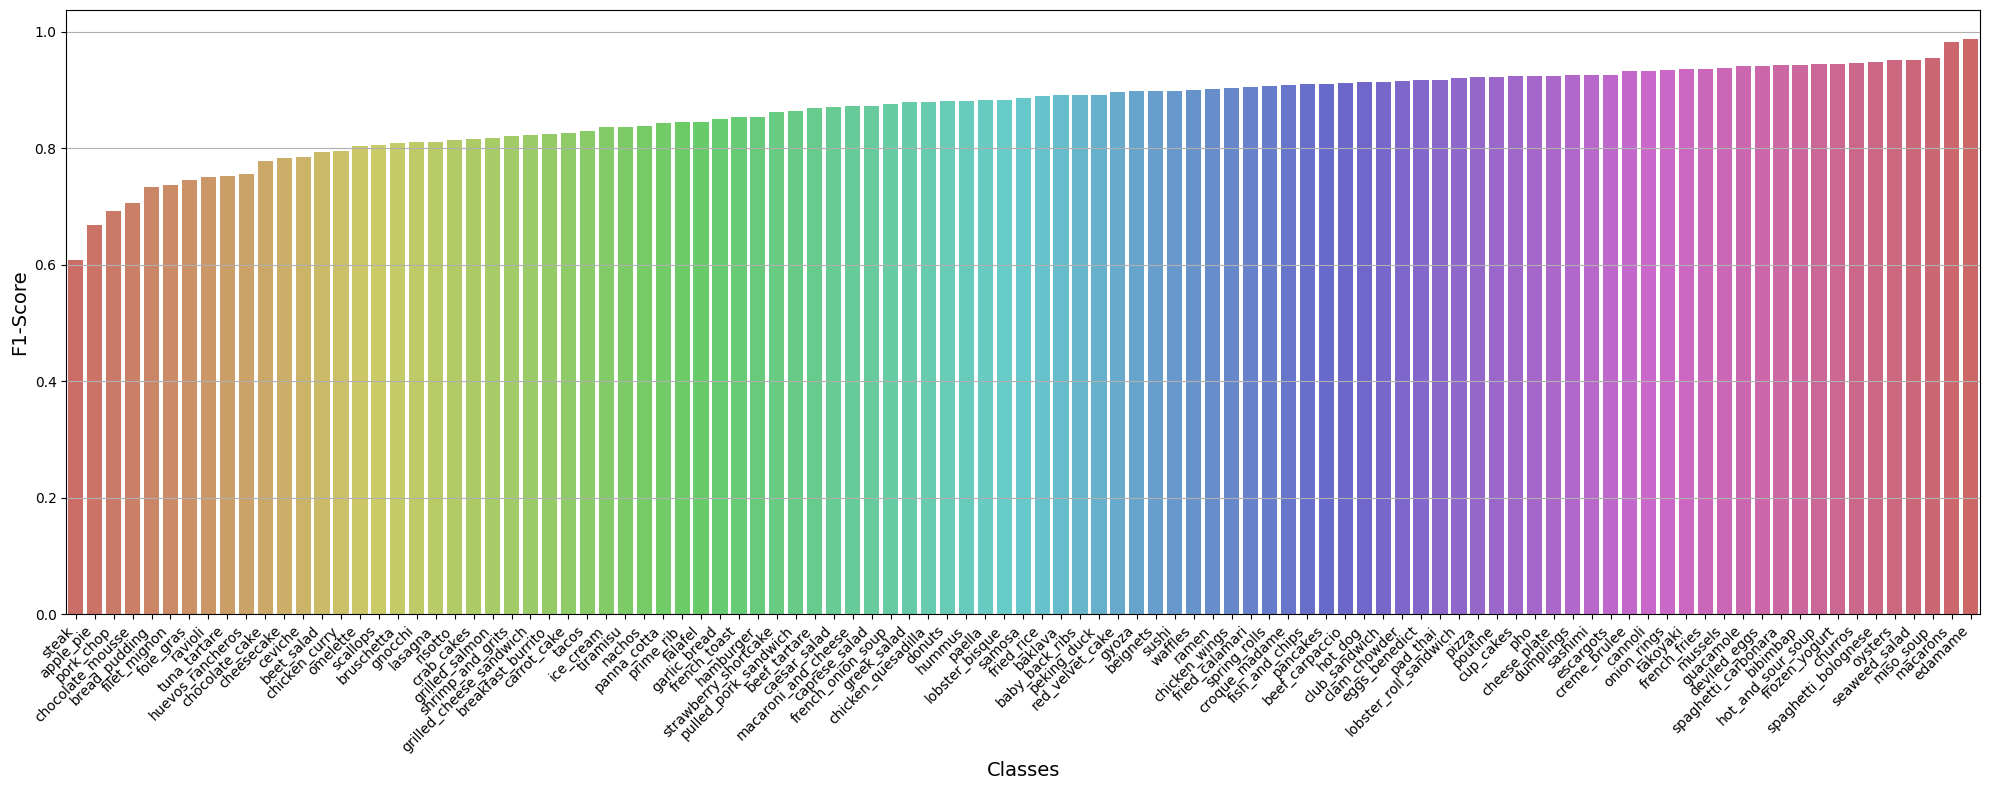

In [10]:
# Create a barplot for F1-scores
plt.figure(figsize=(20, 8))
sns.barplot(
    data=df_worst_class,
    x="Class",
    y="F1-Score",
    hue="Class",
    palette="hls",
    dodge=False,
    legend=False,
)

# Add labels and title
#plt.title("F1-Score of Classes", fontsize=16)
plt.xlabel("Classes", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)

# Rotate x-axis labels to 45 degrees
plt.xticks(rotation=45, ha="right", fontsize=10)

# Improve layout
plt.tight_layout()
plt.grid(visible=True, which="both", axis="y")

# Save picture
#plt.savefig(os.path.join('../images', f'f1-score_vs_food-type.png'), dpi=600)

# Show picture
plt.show()

In [11]:
print(f"Average F1-Score: {round(df_worst_class['F1-Score'].mean(),2)}")

Average F1-Score: 0.87


As can be observed in the above table and figure, the worst performing class is "steak", which obtains an F1-Score of `60.9%` on the test set. In contrast, the best performing class is "edamame", with an F1-Score of almost `100%`. The average F1-Score is `87%`, comparable to that achieved with ViT-Base/16-224.